# Deep Q Networks
------------
You can find the original paper [here](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).

# Bellman equation & Q learning

Formally, **Bellman equation** defines the relationships between a given state (or, in our case, a **state-action pair**) and its successors. While many forms exist, one of the most common is the Bellman equation for the optimal **Q-Value**, which is given by:

\begin{equation}
Q^{*}(s, a)=\sum_{s^{\prime}, r} p\left(s^{\prime}, r | s, a\right)\left[r+\gamma \max _{a^{\prime}} Q^{*}\left(s^{\prime}, a^{\prime}\right)\right]
\end{equation}

Of course, when no uncertainty exists (transition probabilities are either 0 or 1), we have:

\begin{equation}
Q^{*}(s, a)=r(s, a)+\gamma \max _{a^{\prime}} Q^{*}\left(s^{\prime}, a^{\prime}\right)
\end{equation}

**Q-Value** is a measure of the overall expected reward assuming the agent is in state $s$ and performs action $a$, and then continues playing until the end of the episode following some policy $\pi$. It is defined mathematically as:

\begin{equation}
Q^{\pi}\left(s_{t}, a_{t}\right)=E\left[R_{t+1}+\gamma R_{t+2}+\gamma^{2} R_{t+3}+\ldots | s_{t}, a_{t}\right]
\end{equation}

where $R_{t+1}$ is the immediate reward received after performing action $a_{t}$ in state $s_{t}$ and $\gamma$ is the discount factor and controls the importance of the future rewards versus the immediate ones: the lower the discount factor is, the less important future rewards are.

# Imports

In [1]:
import gym
import random, pickle, os.path, math, glob, csv
from timeit import default_timer as timer
from datetime import timedelta
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
%matplotlib inline

import sys
sys.path.insert(0, '../utils')
from qfettes_plot import plot_all_data
from qfettes_wrappers import *
from openai_wrappers import make_atari, wrap_deepmind
from openai_monitor import Monitor

from IPython.display import clear_output

# Deep Q learning

Usually in Deep RL, the **Q-Value** is denoted as $Q(s,a;\theta)$ where $\theta$ represents the parameters of the function approximation used.

<img src="../imgs/approx.png" alt="Drawing" width="200"/>

For *MuJoCo* or *Roboschool* environments, we usually use a simple 2- or 3-layer MLP whereas when using **raw pixels for observations** such as in *Atari 2600* games, we usually use a 1-, 2- or 3-layer CNN.

In our case, since we want to train DQN on *Atari* tasks, we will use a CNN as our function approximation. 

## Network declaration

In [2]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        #self.fc1 = nn.Linear(self.feature_size(), 512)
        #self.fc2 = nn.Linear(512, self.num_actions)
        self.fc1 = nn.Linear(self.feature_size(), 32)
        self.fc2 = nn.Linear(32, self.num_actions)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def feature_size(self):
        # return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)
        return self.conv1(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)

## Experience Replay Memory

As usual RL tasks have no pre-generated training sets which they can learn from, in off-policy learning, our agent must keep records of all the state-transitions it encountered so it can **learn from them later**. The memory-buffer used to store this is often referred to as the **Experience Replay Memory**. There are several types and architectures of these memory buffers — but some very common ones are:
- the *cyclic memory buffers*: they make sure the agent keeps training over its new behavior rather than things that might no longer be relevant
- the *reservoir-sampling-based memory buffers*: they guarantee each state-transition recorded has an even probability to be inserted to the buffer

We use a combination of both.

In [3]:
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size), None, None

    def __len__(self):
        return len(self.memory)

------------

Now let's build the agent class !

## Agent declaration

In [4]:
class Agent(object):
    def __init__(self, config, env, log_dir='/tmp/gym'):
        self.log_dir = log_dir

        self.rewards = []

        self.action_log_frequency = config.ACTION_SELECTION_COUNT_FREQUENCY
        self.action_selections = [0 for _ in range(env.action_space.n)]
        
    def declare_networks(self):
        self.model = DQN(self.num_feats, self.num_actions)
        self.target_model = DQN(self.num_feats, self.num_actions)

    def declare_memory(self):
        self.memory = ExperienceReplayMemory(self.experience_replay_size)
        
    def append_to_replay(self, s, a, r, s_):
        self.memory.push((s, a, r, s_))
    

## Model declaration

In [5]:
class Model(Agent):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym'):
        super().__init__(config=config, env=env, log_dir=log_dir)
        self.device = config.device

        self.gamma = config.GAMMA
        self.lr = config.LR
        self.target_net_update_freq = config.TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = config.EXP_REPLAY_SIZE
        self.batch_size = config.BATCH_SIZE
        self.learn_start = config.LEARN_START
        self.update_freq = config.UPDATE_FREQ

        self.static_policy = static_policy
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.env = env

        self.declare_networks()
            
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Move to correct device
        self.model = self.model.to(self.device)
        self.target_model.to(self.device)

        if self.static_policy:
            self.model.eval()
            self.target_model.eval()
        else:
            self.model.train()
            self.target_model.train()

        self.update_count = 0

        self.declare_memory()

    def prep_minibatch(self):
        # random transition batch is taken from experience replay memory
        transitions, indices, weights = self.memory.sample(self.batch_size)
        
        batch_state, batch_action, batch_reward, batch_next_state = zip(*transitions)

        shape = (-1,)+self.num_feats

        batch_state = torch.tensor(batch_state, device=self.device, dtype=torch.float).view(shape)
        batch_action = torch.tensor(batch_action, device=self.device, dtype=torch.long).squeeze().view(-1, 1)
        batch_reward = torch.tensor(batch_reward, device=self.device, dtype=torch.float).squeeze().view(-1, 1)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), device=self.device, dtype=torch.uint8)
        try: #sometimes all next states are false
            non_final_next_states = torch.tensor([s for s in batch_next_state if s is not None], device=self.device, dtype=torch.float).view(shape)
            empty_next_state_values = False
        except:
            non_final_next_states = None
            empty_next_state_values = True

        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights

    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        #estimate
        current_q_values = self.model(batch_state).gather(1, batch_action)
        
        #target
        with torch.no_grad():
            max_next_q_values = torch.zeros(self.batch_size, device=self.device, dtype=torch.float).unsqueeze(dim=1)
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                max_next_q_values[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
            expected_q_values = batch_reward + self.gamma*max_next_q_values

        diff = (expected_q_values - current_q_values)
        loss = self.MSE(diff)
        loss = loss.mean()

        return loss

    def update(self, s, a, r, s_, frame=0):
        if self.static_policy:
            return None

        self.append_to_replay(s, a, r, s_)

        if frame < self.learn_start or frame % self.update_freq != 0:
            return None

        batch_vars = self.prep_minibatch()

        loss = self.compute_loss(batch_vars)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        self.update_target_model()
        self.save_td(loss.item(), frame)
        self.save_sigma_param_magnitudes(frame)

    def get_action(self, s, eps=0.1):
        with torch.no_grad():
            if np.random.random() >= eps or self.static_policy:
                X = torch.tensor([s], device=self.device, dtype=torch.float)
                a = self.model(X).max(1)[1].view(1, 1)
                return a.item()
            else:
                return np.random.randint(0, self.num_actions)

    def update_target_model(self):
        self.update_count+=1
        self.update_count = self.update_count % self.target_net_update_freq
        if self.update_count == 0:
            self.target_model.load_state_dict(self.model.state_dict())

    def get_max_next_state_action(self, next_states):
        return self.target_model(next_states).max(dim=1)[1].view(-1, 1)

    def finish_nstep(self):
        pass

    def reset_hx(self):
        pass
    
    def MSE(self, x):
        return 0.5 * x.pow(2)
    
    def save_w(self):
        if not(os.path.exists('./saved_agents')):
            os.mkdir('./saved_agents')
        torch.save(self.model.state_dict(), './saved_agents/model.dump')
        torch.save(self.optimizer.state_dict(), './saved_agents/optim.dump')
    
    def load_w(self):
        fname_model = "./saved_agents/model.dump"
        fname_optim = "./saved_agents/optim.dump"

        if os.path.isfile(fname_model):
            self.model.load_state_dict(torch.load(fname_model))
            self.target_model.load_state_dict(self.model.state_dict())

        if os.path.isfile(fname_optim):
            self.optimizer.load_state_dict(torch.load(fname_optim))

    def save_replay(self):
        pickle.dump(self.memory, open('./saved_agents/exp_replay_agent.dump', 'wb'))

    def load_replay(self):
        fname = './saved_agents/exp_replay_agent.dump'
        if os.path.isfile(fname):
            self.memory = pickle.load(open(fname, 'rb'))

    def save_sigma_param_magnitudes(self, tstep):
        with torch.no_grad():
            sum_, count = 0.0, 0.0
            for name, param in self.model.named_parameters():
                if param.requires_grad and 'sigma' in name:
                    sum_+= torch.sum(param.abs()).item()
                    count += np.prod(param.shape)
            
            if count > 0:
                with open(os.path.join(self.log_dir, 'sig_param_mag.csv'), 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow((tstep, sum_/count))

    def save_td(self, td, tstep):
        with open(os.path.join(self.log_dir, 'td.csv'), 'a') as f:
            writer = csv.writer(f)
            writer.writerow((tstep, td))

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_action(self, action, tstep):
        self.action_selections[int(action)] += 1.0/self.action_log_frequency
        if (tstep+1) % self.action_log_frequency == 0:
            with open(os.path.join(self.log_dir, 'action_log.csv'), 'a') as f:
                writer = csv.writer(f)
                writer.writerow(list([tstep]+self.action_selections))
            self.action_selections = [0 for _ in range(len(self.action_selections))]

## Hyperparameters

In [8]:
class Config(object):
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Main agent variables
        self.GAMMA=0.99
        self.LR=1e-4
        
        # Epsilon variables
        self.epsilon_start    = 1.0
        self.epsilon_final    = 0.01
        self.epsilon_decay    = 30000
        self.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

        # Memory
        self.TARGET_NET_UPDATE_FREQ = 1000
        self.EXP_REPLAY_SIZE = 100000
        self.BATCH_SIZE = 32

        # Learning control variables
        self.LEARN_START = 100
        self.MAX_FRAMES=100000
        self.UPDATE_FREQ = 100

        # Data logging parameters
        self.ACTION_SELECTION_COUNT_FREQUENCY = 1000
        
        
config = Config()

## Training

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800

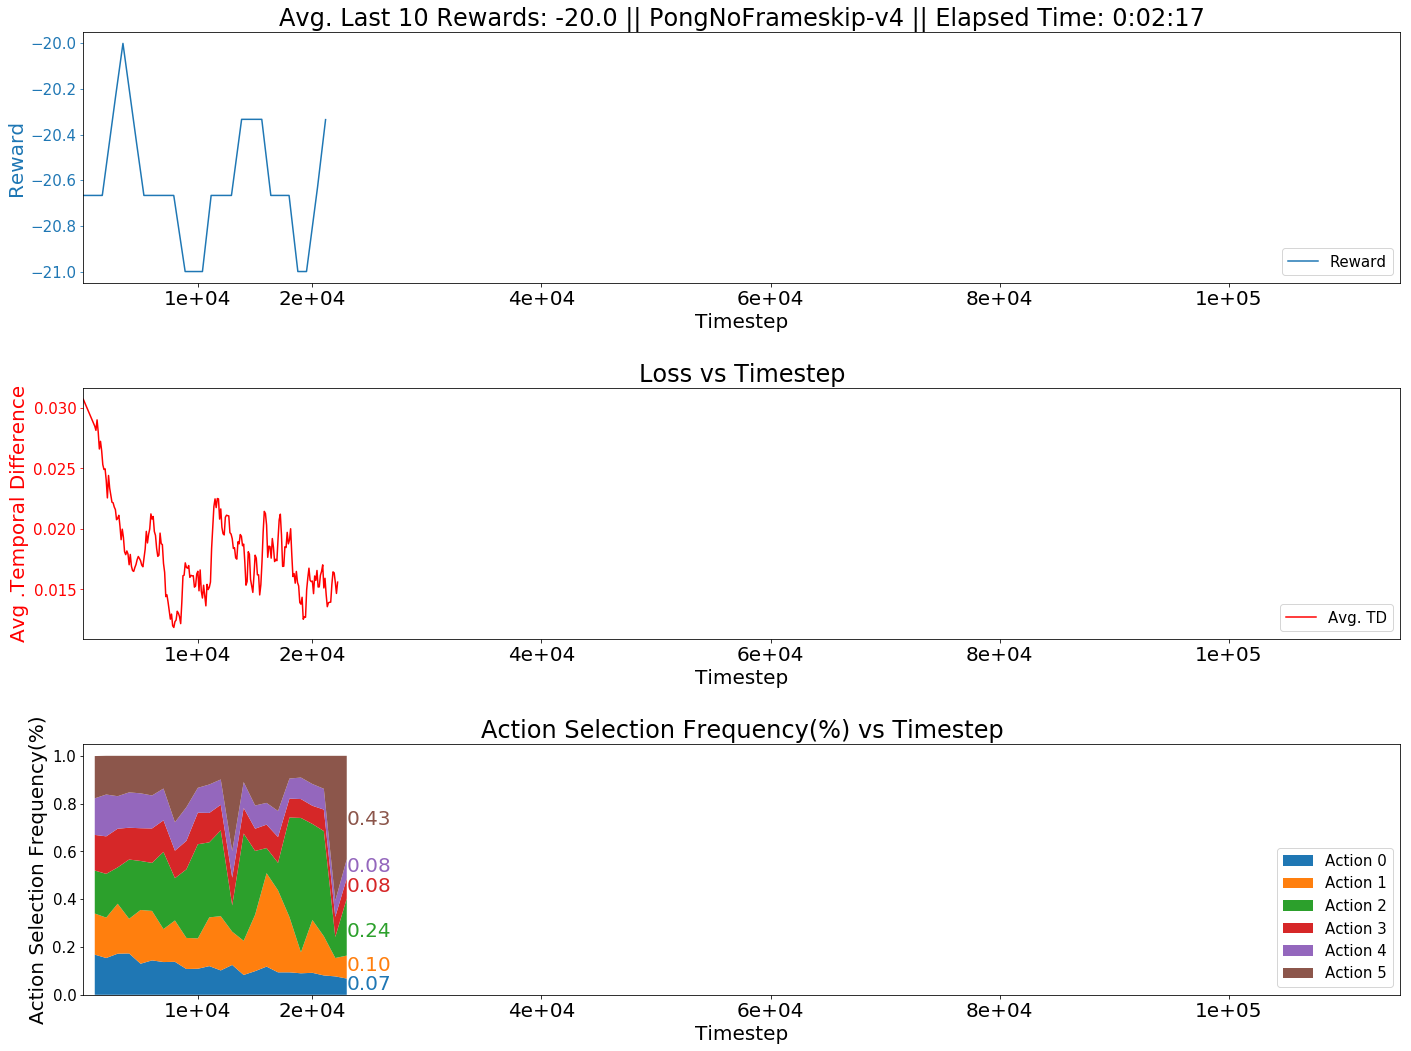

In [ ]:
start=timer()

log_dir = "/tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = Monitor(env, os.path.join(log_dir, env_id))
env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
env    = WrapPyTorch(env)
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    model.save_action(action, frame_idx) #log action selection

    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0

    if frame_idx % 1000 == 0:
        model.save_w()
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'DQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()
plot_all_data(log_dir, env_id, 'DQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)